# Input vector in time: step response

<div class="alert alert-block alert-warning">
<b>Note:</b> Input data needs to be read from a `.csv` file as a DataFrame.
</div>


Considering that the input data are given, e.g., To, Ti_sp, Φ, Qa, Qo, Qi,, create the input vector in time, u, by using `pd_dm4bem.inputs_in_time()`.


Verify with the results obtained in tutorial 3 of `dm4bem`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import pd_dm4bem

## Using `pd_dm4bem`

Create the variables that are inputs
```
# inputs
To = 10 * np.ones(n)
Ti_sp = 20 * np.ones(n)
Φ = Qa = Qo = Qi = np.zeros(n)
```

Then, construct the input vector in time, `u`: 
```
# construct input vector from "ul"
input_data = {'To': To, 'Ti_sp': Ti_sp, 'Φ': Φ, 'Qa': Qa, 'Qo': Qo, 'Qi': Qi}
u = pd_dm4bem.inputs_in_time(ul, input_data)
```

### State-space from dissasembled thermal circuits

In [2]:
"""
pd_dm4bem.tc2ss: with assembling
"""
"""
Obtain the state-space
"""

# Dissasembled thermal circuits
folder_path = "bldg_inputs"
TCd = pd_dm4bem.bldg2TCd(folder_path,
                         TC_auto_number=True)
# For non auto-numbering of thermal circuits TC
# TCd = pd_dm4bem.bldg2TCd(folder_path, TC_auto_number=False)

# Assembled thermal circuit
# from assembly_matrix.csv')
ass_mat = pd.read_csv(folder_path + '/assembly_matrix.csv')
TCm = pd_dm4bem.assemble_TCd_matrix(TCd, ass_mat)

# from assembly_lists.csv'
ass_lists = pd.read_csv(folder_path + '/assembly_lists.csv')
ass_mat = pd_dm4bem.assemble_lists2matrix(ass_lists)
TCl = pd_dm4bem.assemble_TCd_matrix(TCd, ass_mat)

# State-space from TC
[Al, Bl, Cl, Dl, ul] = pd_dm4bem.tc2ss(TCl)

### Step-response
#### Time step and duration

In [3]:
"""
Step response
"""
# time step smaller than dtmax = min(−2/𝜆𝑖)
λ = np.linalg.eig(Al)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)
dt = np.floor(dtmax / 60) * 60   # s

# settling time = 4 * max time constant
time_const = np.array([int(x) for x in sorted(-1 / λ)])
t_settle = 4 * max(-1 / λ)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))        # number of time steps
t = np.arange(0, n * dt, dt)            # time vector for n time steps

#### Input data

In [4]:
# inputs
To = 10 * np.ones(n)
Ti_sp = 20 * np.ones(n)
Φ = Qa = Qo = Qi = np.zeros(n)

#### Input vector `u` in time

In [5]:
# construct input vector from "ul"
# u = pd.concat([pd.Series(eval(col), name=col) for col in ul], axis=1)
input_data = {'To': To, 'Ti_sp': Ti_sp, 'Φ': Φ, 'Qa': Qa, 'Qo': Qo, 'Qi': Qi}
u = pd_dm4bem.inputs_in_time(ul, input_data)

#### Integration in time

In [6]:
# initial conditions
n_s = Al.shape[0]                       # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])     # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])     # implicit Euler in time t


I = np.eye(n_s)                         # identity matrix

Bl = Bl.rename(columns=ul)
Dl = Dl.rename(columns=ul)

# time integration
for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * Al) @\
        θ_exp[:, k] + dt * Bl @ u.iloc[k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * Al) @\
        (θ_imp[:, k] + dt * Bl @ u.iloc[k])

# outputs
y_exp = Cl @ θ_exp + Dl @  u.T
y_imp = Cl @ θ_imp + Dl @  u.T

#### Plot results

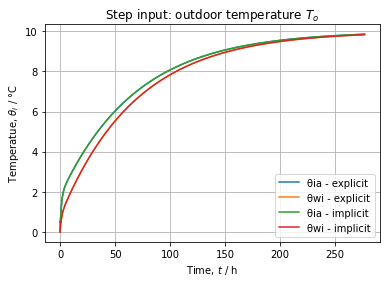

In [7]:
# plot
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.values.T, t / 3600, y_imp.values.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['θia - explicit', 'θwi - explicit',
           'θia - implicit', 'θwi - implicit'])
ax.grid()
plt.show()

## Using dm4bem and tutorial 3 (simple building)

dt = 180.0 s = 3 min
Settling time: 995159 s = 16586.0 min = 276.43 h = 11.52 days


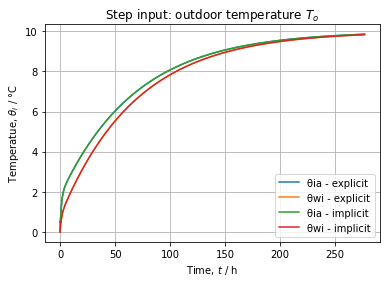

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 16 13:57:13 2023

@author: cghiaus

Example from 03CubicBuilding.ipynb and 041tc2ss_ass.ipynb
treated with:
    dm4bem.tc2ss: without assembling
    pd_dm4bem.tc2ss: with assembling

Use the same notations figure TC.svg

"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem
import pd_dm4bem

"""
dm4bem.tc2ss: without assembling
"""
TC0 = pd.read_csv("./bldg_inputs/TC0.csv")
TC1 = pd.read_csv("./bldg_inputs/TC1.csv")
TC2 = pd.read_csv("./bldg_inputs/TC2.csv")
TC3 = pd.read_csv("./bldg_inputs/TC3.csv")

wS = pd.read_csv("./bldg_inputs/walls_out.csv")

w = pd.read_csv("./bldg_inputs/wall_types.csv")
w0 = w[w['type'] == 0]
w0.set_index('Material', inplace=True)

A = np.zeros([12, 8])       # n° of branches X n° of nodes
A[0, 7], A[0, 1] = -1, 1
A[1, 0] = 1
A[2, 0], A[2, 1] = -1, 1
A[3, 1], A[3, 2] = -1, 1
A[4, 2] = 1
A[5, 2] = 1
A[6, 3] = 1
A[7, 3], A[7, 4] = -1, 1
A[8, 4], A[8, 5] = -1, 1
A[9, 5], A[9, 6] = -1, 1
A[10, 6], A[10, 7] = -1, 1
A[11, 7], A[11, 2] = -1, 1


G = np.zeros(A.shape[0])

G[0] = TC0.loc[0]['G']
G[1] = TC1.loc[0]['G']
G[2] = TC1.loc[1]['G']
G[3] = TC1.loc[2]['G']
G[4] = TC2.loc[0]['G']
G[5] = TC3.loc[0]['G']
G[6] = wS.loc[0]['h0'] * wS.loc[0]['Area']
G[7] = G[8] = w0.loc[
    'Insulation']['Conductivity'] / (w0.loc[
        'Insulation']['Width'] / 2) * wS.loc[0]['Area']
G[9] = G[10] = w0.loc[
    'Concrete']['Conductivity'] / (w0.loc[
        'Concrete']['Width'] / 2) * wS.loc[0]['Area']
G[11] = wS.loc[0]['h1'] * wS.loc[0]['Area']


# C = np.array([0., 239580., 0., 18216000., 0., 0., 32400., 1089000.])

C = np.zeros(A.shape[1])

C[0] = TC1.loc[TC1['A'] == 'C', 'θg']
C[2] = TC2.loc[TC2['A'] == 'C', 'θ0']
C[4] = w0.loc[
    'Insulation']['Density'] * w0.loc[
        'Insulation']['Specific heat'] * w0.loc[
            'Insulation']['Width'] * wS.loc[0]['Area']
C[6] = w0.loc[
    'Concrete']['Density'] * w0.loc[
        'Concrete']['Specific heat'] * w0.loc[
            'Concrete']['Width'] * wS.loc[0]['Area']

b = np.zeros(12)        # all branches
b[[1, 4, 5, 6]] = 1     # branches with temperature sources

f = np.zeros(8)         # all nodes
f[[0, 2, 3, 7]] = 1     # nodes with heat-flow sources

y = np.zeros(8)         # nodes
y[[2, 7]] = 1           # nodes: in wall surface, in air

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, np.diag(G), np.diag(C), b, f, y)

# ------------------
# Dynamic simulation
# ------------------
# time step smaller than dtmax = min(−2/𝜆𝑖)
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
dtmax = 2 * min(-1. / λ)
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

# Step response
# -------------
# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))        # number of time steps
t = np.arange(0, n * dt, dt)            # time vector for n time steps

# input vector
u = np.zeros([8, n])                    # u = [To To Ti_sp To Φ Qa Qo Qi]
u[[0, 1, 3], :] = 10 * np.ones([3, n])  # To = 10 for n time steps
u[2, :] = 20 * np.ones([1, n])          # Ti_sp

# initial conditions
n_s = As.shape[0]                       # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])     # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])     # implicit Euler in time t

# time integration
I = np.eye(n_s)                         # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

# outputs
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u

# plot
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['θia - explicit', 'θwi - explicit',
           'θia - implicit', 'θwi - implicit'])
ax.grid()
plt.show()